## Setup environment

In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
#ส่วนเสริม
import sys
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Python version: 3.11.14 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 18:30:03) [MSC v.1929 64 bit (AMD64)]
Python executable: c:\Users\User\anaconda3\envs\monai\python.exe
PyTorch version: 2.5.1+cu121
CUDA available: True
PyTorch version: 2.5.1+cu121
CUDA available: True


In [3]:
#ส่วนเสริม
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("⚠️ CUDA is not available. Running on CPU.")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU Device: NVIDIA GeForce RTX 3060
Number of GPUs: 1


## Setup imports

In [4]:
import glob
import sys
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

import nibabel as nib
import numpy as np
from monai.config import print_config
from monai.data import ArrayDataset, create_test_image_3d, decollate_batch, DataLoader
from monai.handlers import (
    MeanDice,
    MLFlowHandler,
    StatsHandler,
    TensorBoardImageHandler,
    TensorBoardStatsHandler,
)

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ResizeWithPadOrCropd,
    RandScaleIntensityd,
    RandGaussianNoised,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch
print(torch.__version__)
print_config()

c:\Users\User\anaconda3\envs\monai\Lib\site-packages\ignite\handlers\checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


2.5.1+cu121
MONAI version: 1.6.dev2542
Numpy version: 2.3.4
Pytorch version: 2.5.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 612f3dd3cba4d73cfcea4b5329079e20aa31523d
MONAI __file__: c:\<username>s\<username>\anaconda3\envs\monai\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.3
ITK version: 5.4.5
Nibabel version: 5.3.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.16.3
Pillow version: 12.0.0
Tensorboard version: 2.20.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.20.1+cu121
Numpy version: 2.3.4
Pytorch version: 2.5.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 612f3dd3cba4d73cfcea4b5329079e20aa31523d
MONAI __file__: c:\<username>s\<username>\anaconda3\envs\monai\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.3
ITK version: 5.4.5
Nibabel version: 5.3.2
s

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Users\User\AppData\Local\Temp\tmpr0euny7y


## Setup transforms for training and validation

### ใช้ Data ของ LumASe (คุณsun)

In [6]:
from monai.transforms import LoadImaged, SpatialPadd, ResizeWithPadOrCropd

train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(
        keys=["image", "label"],
        pixdim=(1.5, 1.5, 2.0),
        mode=("bilinear", "nearest"),
    ),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-200,
        a_max=1000,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
    
    # ⭐ เพิ่มบรรทัดนี้: บังคับให้ขนาดเป็น (เช่น 64³)
    ResizeWithPadOrCropd(
        keys=["image", "label"],
        spatial_size=(64, 64, 64), #(เช่น 64³)
    ),
    
    RandFlipd(keys=["image", "label"], spatial_axis=[0], prob=0.50), # เดิม 10% → 50%
    RandFlipd(keys=["image", "label"], spatial_axis=[1], prob=0.50), # 10% → 50%
    RandFlipd(keys=["image", "label"], spatial_axis=[2], prob=0.50), # 10% → 50%
    RandRotate90d(keys=["image", "label"], prob=0.50, max_k=3),      # 10% → 50%
    RandShiftIntensityd(keys=["image"], offsets=0.10, prob=0.50),

    # RandScaleIntensityd(keys=["image"], factors=0.1, prob=0.5),
    # RandGaussianNoised(keys=["image"], prob=0.2, mean=0.0, std=0.01),
])

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(
        keys=["image", "label"],
        pixdim=(1.5, 1.5, 2.0),
        mode=("bilinear", "nearest"),
    ),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-200,
        a_max=1000,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
    
    # ⭐ เพิ่มใน val ด้วย
    ResizeWithPadOrCropd(
        keys=["image", "label"],
        spatial_size=(64, 64, 64), #(เช่น 64³)
    ),
])

print("✅ Transforms configured with ResizeWithPadOrCrop")

✅ Transforms configured with ResizeWithPadOrCrop


monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.


## Download dataset and format in the folder.

### ใช้ Data ของ LumASe (คุณsun)

#### แยกไฟล์ที่ seg กับ ไม่seg

In [7]:
import os
import glob

data_root = "E:/Senior Project MONAI/tutorials-main/3d_segmentation/L1-L5FineSegMix-663case"

print("🔍 Analyzing L1-L5FineSegMix-663case dataset...")
print(f"📂 Root: {data_root}\n")

# ค้นหาไฟล์ทั้งหมด
all_files = sorted(glob.glob(f"{data_root}/*.nii.gz"))

# แยก image และ label files
image_files = [f for f in all_files if not f.endswith('_seg.nii.gz')]
label_files = [f for f in all_files if f.endswith('_seg.nii.gz')]

print(f"📊 Dataset Statistics:")
print(f"   Total files: {len(all_files)}")
print(f"   Image files: {len(image_files)}")
print(f"   Label files (segmented): {len(label_files)}")

# จับคู่ image กับ label
data_pairs = []
for img_path in image_files:
    # หา label ที่ตรงกัน (เพิ่ม _seg)
    label_path = img_path.replace('.nii.gz', '_seg.nii.gz')
    
    if os.path.exists(label_path):
        data_pairs.append({
            "image": img_path,
            "label": label_path
        })

print(f"\n✅ Matched pairs: {len(data_pairs)}")

# แสดงตัวอย่าง 5 pairs
if len(data_pairs) > 0:
    print("\n📄 Sample data pairs:")
    for i, pair in enumerate(data_pairs[:5]):
        img_name = os.path.basename(pair["image"])
        lbl_name = os.path.basename(pair["label"])
        print(f"   {i+1}. Image: {img_name}")
        print(f"      Label: {lbl_name}")

print(f"\n🚀 Variable created: data_pairs (list of {len(data_pairs)} items)")
print(f"   Each item has 'image' and 'label' paths")

🔍 Analyzing L1-L5FineSegMix-663case dataset...
📂 Root: E:/Senior Project MONAI/tutorials-main/3d_segmentation/L1-L5FineSegMix-663case

📊 Dataset Statistics:
   Total files: 1326
   Image files: 663
   Label files (segmented): 663

✅ Matched pairs: 663

📄 Sample data pairs:
   1. Image: 101002594062_L5.nii.gz
      Label: 101002594062_L5_seg.nii.gz
   2. Image: 101002745900_L4.nii.gz
      Label: 101002745900_L4_seg.nii.gz
   3. Image: 101002745900_L5.nii.gz
      Label: 101002745900_L5_seg.nii.gz
   4. Image: 101002826892_L4.nii.gz
      Label: 101002826892_L4_seg.nii.gz
   5. Image: 101002913418_L4.nii.gz
      Label: 101002913418_L4_seg.nii.gz

🚀 Variable created: data_pairs (list of 663 items)
   Each item has 'image' and 'label' paths


#### แบ่ง Data ที่ใช้ train/val/test

In [8]:
from sklearn.model_selection import train_test_split

print("🔄 Splitting dataset into Train/Val/Test...")
print(f"📊 Total cases: {len(data_pairs)}\n")

# ⭐ ตั้งค่าตรงนี้: เลือกโหมดการแบ่ง data
USE_TEST_SET = False  # True = แบ่ง Train/Val/Test, False = แบ่ง Train/Val เท่านั้น

if USE_TEST_SET:
    # โหมด 1: แบ่งเป็น Train / Val / Test
    # Step 1: แบ่ง train และ temp 
    train_files, temp_files = train_test_split(
        data_pairs, 
        test_size=0.3,  # เช่น (0.3 = 30% สำหรับ val + test)
        random_state=42,
        shuffle=True
    )
    
    # Step 2: แบ่ง temp → val + test
    val_files, test_files = train_test_split(
        temp_files,
        test_size=0.5,  # แบ่งครึ่ง → val และ test เท่ากัน
        random_state=42,
        shuffle=True
    )
    
    # แสดงผลลัพธ์
    print(f"✅ Dataset split completed:")
    print(f"   Training:   {len(train_files):3d} cases ({len(train_files)/len(data_pairs)*100:.1f}%)")
    print(f"   Validation: {len(val_files):3d} cases ({len(val_files)/len(data_pairs)*100:.1f}%)")
    print(f"   Test:       {len(test_files):3d} cases ({len(test_files)/len(data_pairs)*100:.1f}%)")
    print(f"   Total:      {len(train_files) + len(val_files) + len(test_files):3d} cases")
    
else:
    # โหมด 2: แบ่งเป็น Train / Val เท่านั้น
    train_files, val_files = train_test_split(
        data_pairs,
        test_size=0.15,  # เช่น (0.2 = 20% สำหรับ validation)
        random_state=42,
        shuffle=True
    )
    
    test_files = []  # ไม่มี test set
    
    # แสดงผลลัพธ์
    print(f"✅ Dataset split completed:")
    print(f"   Training:   {len(train_files):3d} cases ({len(train_files)/len(data_pairs)*100:.1f}%)")
    print(f"   Validation: {len(val_files):3d} cases ({len(val_files)/len(data_pairs)*100:.1f}%)")
    print(f"   Test:       0 cases (not used)")
    print(f"   Total:      {len(train_files) + len(val_files):3d} cases")

# แสดงตัวอย่าง
print("\n📄 Sample train files:")
for i, pair in enumerate(train_files[:3]):
    print(f"   {i+1}. {os.path.basename(pair['image'])}")

if USE_TEST_SET and len(test_files) > 0:
    print("\n📄 Sample test files (will NOT be used in training):")
    for i, pair in enumerate(test_files[:3]):
        print(f"   {i+1}. {os.path.basename(pair['image'])}")

print("\n🚀 Variables created:")
print(f"   - train_files: {len(train_files)} items")
print(f"   - val_files:   {len(val_files)} items")
if USE_TEST_SET:
    print(f"   - test_files:  {len(test_files)} items (ใช้สำหรับ test ภายหลัง)")
else:
    print(f"   - test_files:  0 items (ไม่ใช้ test set)")

🔄 Splitting dataset into Train/Val/Test...
📊 Total cases: 663

✅ Dataset split completed:
   Training:   563 cases (84.9%)
   Validation: 100 cases (15.1%)
   Test:       0 cases (not used)
   Total:      663 cases

📄 Sample train files:
   1. 101004306052_L2.nii.gz
   2. 101007662645_L4.nii.gz
   3. 101005607132_L4.nii.gz

🚀 Variables created:
   - train_files: 563 items
   - val_files:   100 items
   - test_files:  0 items (ไม่ใช้ test set)


### สร้าง Data Loader

In [9]:
print("🔄 Creating datasets and dataloaders...")
print("⚠️ Memory-optimized settings for 12GB GPU\n")

# สร้าง Dataset
train_ds = CacheDataset(
    data=train_files,
    transform=train_transforms,
    cache_rate=0.0,  # ปิด cache เพื่อประหยัด memory
    num_workers=2,
)

val_ds = CacheDataset(
    data=val_files,
    transform=val_transforms,
    cache_rate=0.0,
    num_workers=1,
)

# สร้าง DataLoader
train_loader = DataLoader(
    train_ds,
    batch_size=1,
    shuffle=True,
    num_workers=0,      # ใช้ main thread อย่างเดียว
    pin_memory=False,   # ปิด pin_memory เพื่อประหยัด GPU memory
)

val_loader = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
)

print("✅ Datasets created:")
print(f"   Train dataset: {len(train_ds)} samples")
print(f"   Val dataset:   {len(val_ds)} samples")

print("\n✅ DataLoaders ready:")
print(f"   Train loader: {len(train_loader)} batches")
print(f"   Val loader:   {len(val_loader)} batches")

🔄 Creating datasets and dataloaders...
⚠️ Memory-optimized settings for 12GB GPU

✅ Datasets created:
   Train dataset: 563 samples
   Val dataset:   100 samples

✅ DataLoaders ready:
   Train loader: 563 batches
   Val loader:   100 batches


## Check Memory

In [10]:
#ส่วนเสริม
import psutil
import os

process = psutil.Process(os.getpid())
print(f"Memory usage: {process.memory_info().rss / 1024 ** 3:.2f} GB")

Memory usage: 0.70 GB


## Check data shape and visualize

### ใช้ DATA ของ LumASe (คุณsun)

🔍 Checking data shape and content...

📄 Sample file (index 0):
   Image: 101004306052_L2.nii.gz
   Label: 101004306052_L2_seg.nii.gz

📊 ORIGINAL FILE (before transforms):
   Image shape: (298, 274, 66)
   Label shape: (298, 274, 66)
   Data type: float64
   Value range: -674.0 to 2044.0
   Spacing: (np.float32(0.3046875), np.float32(0.3046875), np.float32(0.8))

📊 Label Information:
   Unique labels: [0. 1. 2. 3. 4. 5. 6. 7.]
   Number of classes: 8

📈 Class distribution:
   Class 0: 4,584,294 voxels (85.07%)
   Class 1: 13,393 voxels (0.25%)
   Class 2: 120,302 voxels (2.23%)
   Class 3: 23,358 voxels (0.43%)
   Class 4: 45,480 voxels (0.84%)
   Class 5: 49,252 voxels (0.91%)
   Class 6: 28,547 voxels (0.53%)
   Class 7: 524,406 voxels (9.73%)

🔍 CHECKING TRANSFORMED DATA (after transforms)

📊 ORIGINAL FILE (before transforms):
   Image shape: (298, 274, 66)
   Label shape: (298, 274, 66)
   Data type: float64
   Value range: -674.0 to 2044.0
   Spacing: (np.float32(0.3046875), np.flo

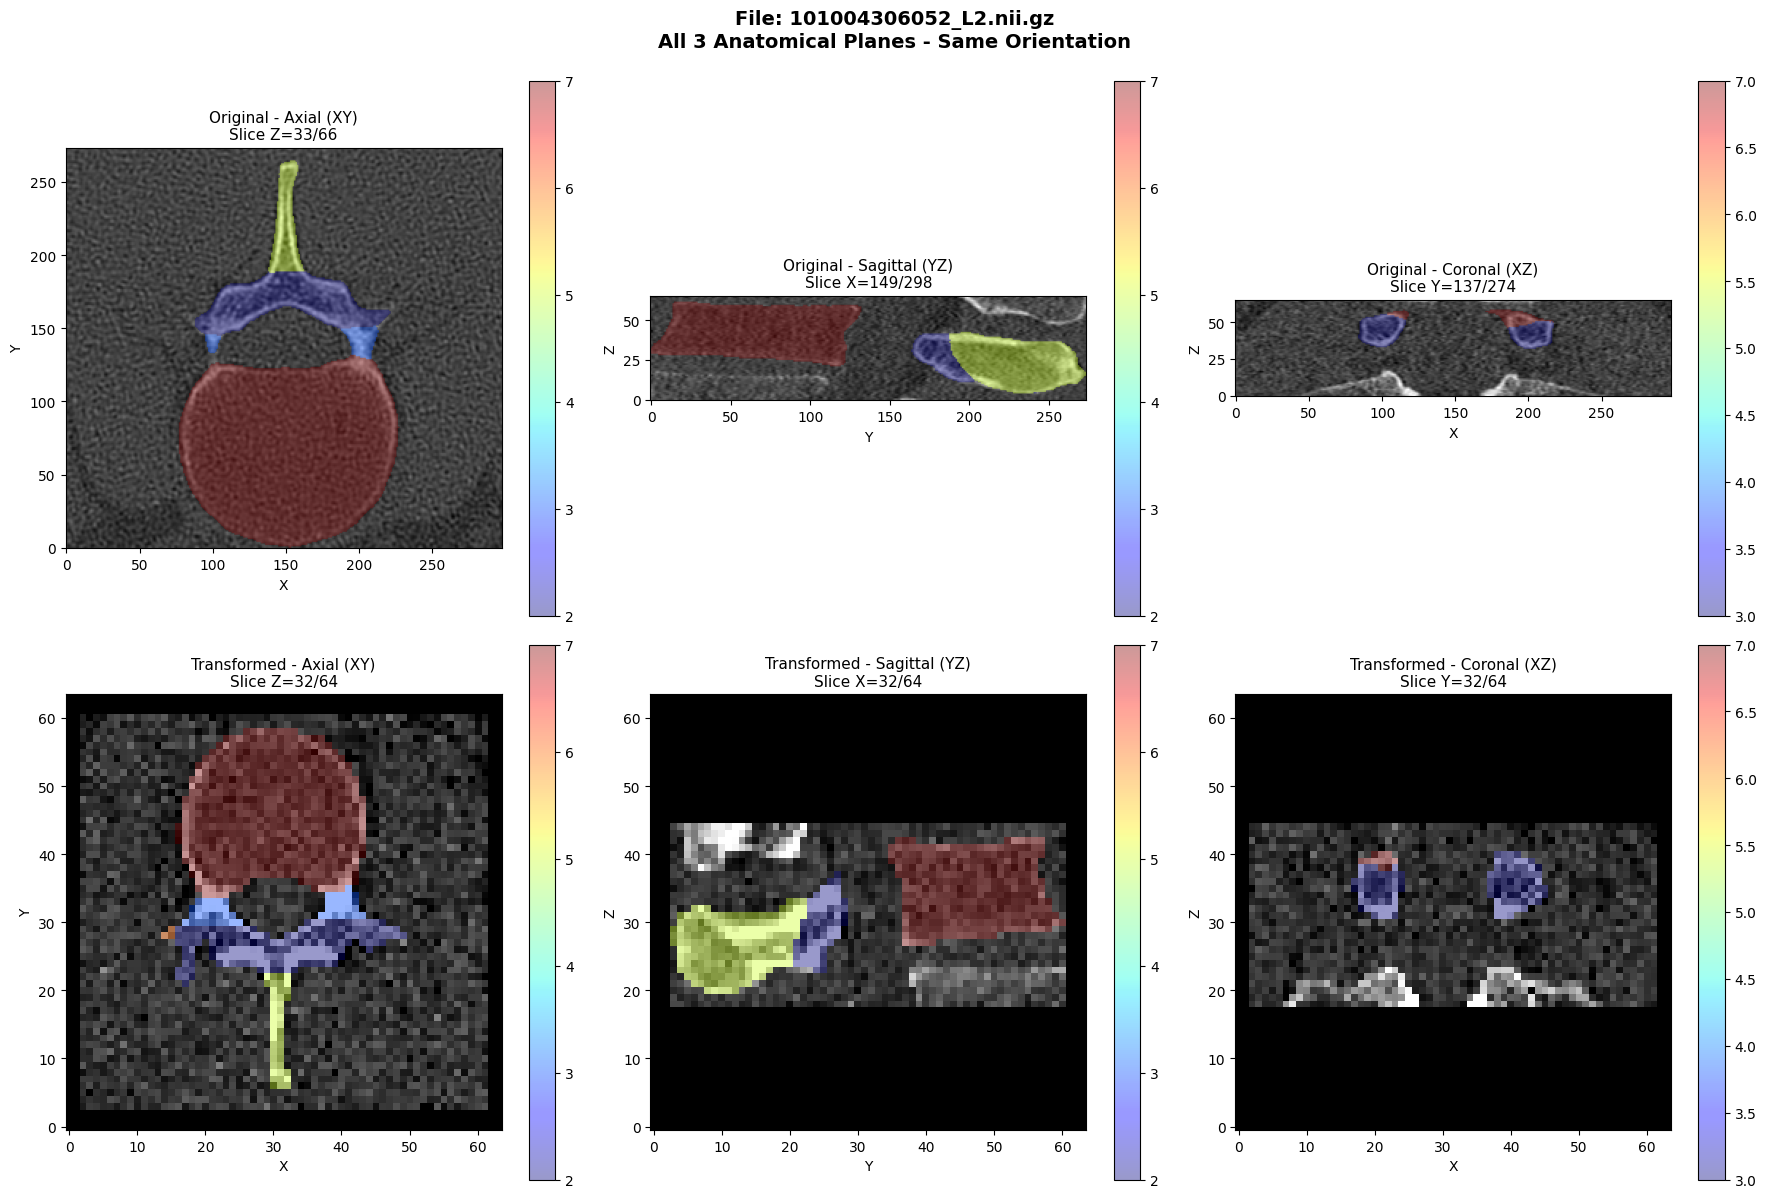


🔍 PADDING ANALYSIS (Axial View)


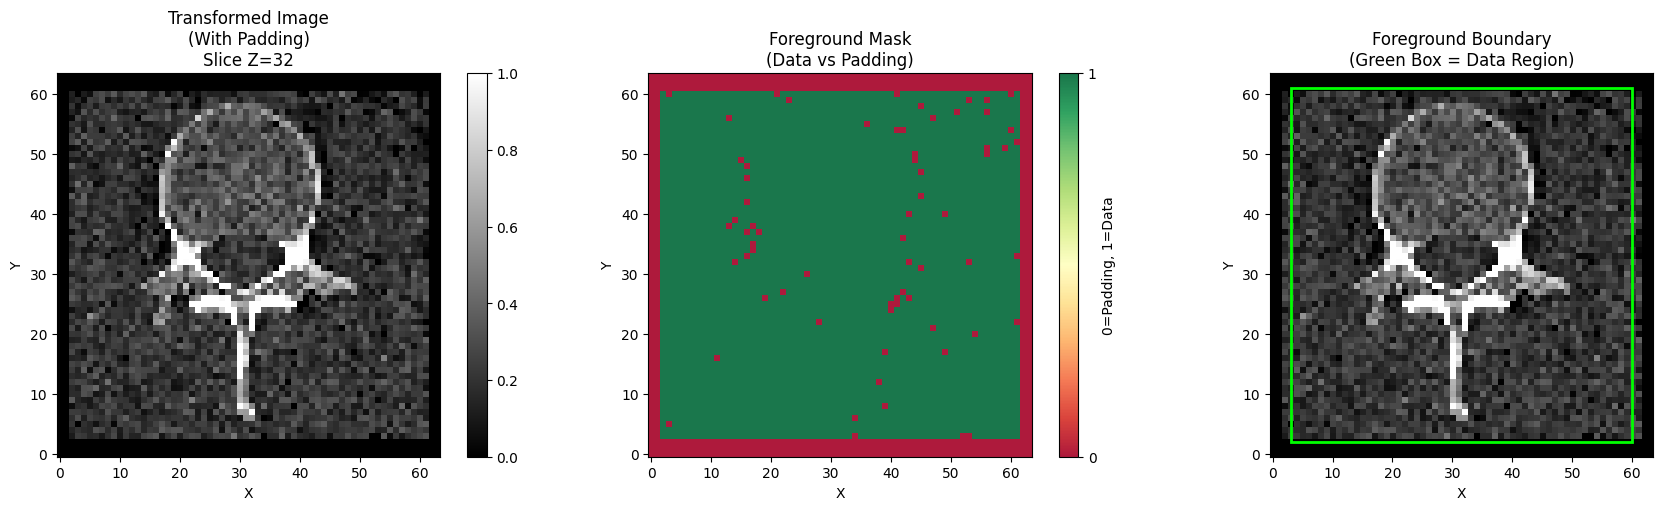

✅ Padding analysis shows 64.2% of volume is padding

✅ Data check completed!


In [11]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

print("🔍 Checking data shape and content...")
print("="*60)

# 🎯 เปลี่ยนค่าตรงนี้เพื่อดูไฟล์อื่น
SAMPLE_INDEX = 0        # เลขลำดับไฟล์ (0 ถึง 463)
DATASET = train_files   # train_files, val_files, หรือ test_files
SLICE_POSITION = 0.5    # 0.5 = กลางพอดี, 0.3 = ต้นๆ, 0.7 = ท้ายๆ

# เลือกไฟล์
sample_pair = DATASET[SAMPLE_INDEX]

img_path = sample_pair["image"]
lbl_path = sample_pair["label"]

print(f"\n📄 Sample file (index {SAMPLE_INDEX}):")
print(f"   Image: {os.path.basename(img_path)}")
print(f"   Label: {os.path.basename(lbl_path)}")

# ============================================================
# ✅ PART 1: โหลดไฟล์ต้นฉบับ (ก่อน transforms)
# ============================================================
img_nib = nib.load(img_path)
lbl_nib = nib.load(lbl_path)

img_data = img_nib.get_fdata()
lbl_data = lbl_nib.get_fdata()

# แสดงข้อมูล
print(f"\n📊 ORIGINAL FILE (before transforms):")
print(f"   Image shape: {img_data.shape}")
print(f"   Label shape: {lbl_data.shape}")
print(f"   Data type: {img_data.dtype}")
print(f"   Value range: {img_data.min():.1f} to {img_data.max():.1f}")
print(f"   Spacing: {img_nib.header.get_zooms()}")

print(f"\n📊 Label Information:")
print(f"   Unique labels: {np.unique(lbl_data)}")
print(f"   Number of classes: {len(np.unique(lbl_data))}")

# นับจำนวน voxels แต่ละ class
print(f"\n📈 Class distribution:")
for label_id in np.unique(lbl_data):
    count = np.sum(lbl_data == label_id)
    percentage = (count / lbl_data.size) * 100
    print(f"   Class {int(label_id)}: {count:,} voxels ({percentage:.2f}%)")

# ============================================================
# ✅ PART 2: เช็คขนาดหลัง transforms (ที่ส่งเข้า model)
# ============================================================
print(f"\n{'='*60}")
print("🔍 CHECKING TRANSFORMED DATA (after transforms)")
print(f"{'='*60}")

# โหลดข้อมูลหลัง transforms
sample_transformed = val_ds[SAMPLE_INDEX]
img_transformed = sample_transformed["image"]
lbl_transformed = sample_transformed["label"]

print(f"\n📊 TRANSFORMED DATA (what model receives):")
print(f"   Image shape: {img_transformed.shape}")  # (C, H, W, D)
print(f"   Label shape: {lbl_transformed.shape}")

# เช็คว่ามีส่วนไหนเป็น padding (พื้นที่ดำ)
img_np = img_transformed[0].cpu().numpy()  # เอา channel แรก
non_zero_coords = np.where(img_np > 0.01)  # threshold เล็กน้อย

if len(non_zero_coords[0]) > 0:
    # หาขอบเขตของ foreground
    min_x, max_x = non_zero_coords[0].min(), non_zero_coords[0].max()
    min_y, max_y = non_zero_coords[1].min(), non_zero_coords[1].max()
    min_z, max_z = non_zero_coords[2].min(), non_zero_coords[2].max()
    
    foreground_size = (max_x - min_x + 1, max_y - min_y + 1, max_z - min_z + 1)
    
    print(f"\n📌 Foreground Region (non-padding area):")
    print(f"   X range: {min_x:3d} to {max_x:3d} (size: {foreground_size[0]})")
    print(f"   Y range: {min_y:3d} to {max_y:3d} (size: {foreground_size[1]})")
    print(f"   Z range: {min_z:3d} to {max_z:3d} (size: {foreground_size[2]})")
    print(f"   Foreground size: {foreground_size}")
    
    # คำนวณ % พื้นที่ที่ใช้จริง
    total_voxels = img_np.size
    foreground_voxels = np.prod(foreground_size)
    usage_percent = (foreground_voxels / total_voxels) * 100
    
    print(f"\n📊 Space Usage Analysis:")
    print(f"   Total volume:        {img_transformed.shape[1:]} = {total_voxels:,} voxels")
    print(f"   Foreground volume:   {foreground_size} = {foreground_voxels:,} voxels")
    print(f"   ✅ Used space:       {usage_percent:.1f}%")
    print(f"   ⚫ Padding (black):  {100-usage_percent:.1f}%")
    
    # ✅ แนะนำขนาดที่เหมาะสม
    print(f"\n💡 RECOMMENDATION:")
    if usage_percent < 40:
        print(f"   ⚠️  TOO MUCH PADDING! ({100-usage_percent:.1f}% wasted)")
        print(f"   ✅ Suggested spatial_size: ({max(foreground_size[0], 64)}, {max(foreground_size[1], 64)}, {max(foreground_size[2], 64)})")
        print(f"   📌 Or try (64, 64, 64) instead of (96, 96, 96)")
    elif usage_percent < 60:
        print(f"   ⚠️  Moderate padding ({100-usage_percent:.1f}%)")
        print(f"   ✅ Consider using (64, 64, 64) to save memory")
    else:
        print(f"   ✅ Good space usage! Current size (96, 96, 96) is reasonable")

# ============================================================
# ✅ PART 3: Visualization - แสดงทั้ง 3 แกน (ทิศทางเดียวกัน!)
# ============================================================
print(f"\n{'='*60}")
print("📊 VISUALIZATION - All 3 Axes (Same Orientation)")
print(f"{'='*60}")

# เลือก slice positions
slice_x = int(img_data.shape[0] * SLICE_POSITION)
slice_y = int(img_data.shape[1] * SLICE_POSITION)
slice_z = int(img_data.shape[2] * SLICE_POSITION)

# สำหรับ transformed (ใช้ตำแหน่งเดียวกัน)
trans_slice_x = int(img_transformed.shape[1] * SLICE_POSITION)
trans_slice_y = int(img_transformed.shape[2] * SLICE_POSITION)
trans_slice_z = int(img_transformed.shape[3] * SLICE_POSITION)

print(f"\n📍 Viewing position: {SLICE_POSITION*100:.0f}% through each axis")
print(f"   Original slices:    X={slice_x}, Y={slice_y}, Z={slice_z}")
print(f"   Transformed slices: X={trans_slice_x}, Y={trans_slice_y}, Z={trans_slice_z}")

# สร้างรูป 2 แถว x 3 คอลัมน์ (3 แกน)
fig = plt.figure(figsize=(18, 12))

# ============================================================
# แถวที่ 1: รูปต้นฉบับ - 3 แกน (ใช้ origin='lower' ทั้งหมด)
# ============================================================
plt.subplot(2, 3, 1)
plt.title(f"Original - Axial (XY)\nSlice Z={slice_z}/{img_data.shape[2]}", fontsize=11)
plt.imshow(img_data[:, :, slice_z].T, cmap='gray', origin='lower')
plt.imshow(np.ma.masked_where(lbl_data[:, :, slice_z].T == 0, lbl_data[:, :, slice_z].T), 
           cmap='jet', alpha=0.4, origin='lower')
plt.xlabel('X'); plt.ylabel('Y')
plt.colorbar()

plt.subplot(2, 3, 2)
plt.title(f"Original - Sagittal (YZ)\nSlice X={slice_x}/{img_data.shape[0]}", fontsize=11)
plt.imshow(img_data[slice_x, :, :].T, cmap='gray', origin='lower')
plt.imshow(np.ma.masked_where(lbl_data[slice_x, :, :].T == 0, lbl_data[slice_x, :, :].T), 
           cmap='jet', alpha=0.4, origin='lower')
plt.xlabel('Y'); plt.ylabel('Z')
plt.colorbar()

plt.subplot(2, 3, 3)
plt.title(f"Original - Coronal (XZ)\nSlice Y={slice_y}/{img_data.shape[1]}", fontsize=11)
plt.imshow(img_data[:, slice_y, :].T, cmap='gray', origin='lower')
plt.imshow(np.ma.masked_where(lbl_data[:, slice_y, :].T == 0, lbl_data[:, slice_y, :].T), 
           cmap='jet', alpha=0.4, origin='lower')
plt.xlabel('X'); plt.ylabel('Z')
plt.colorbar()

# ============================================================
# แถวที่ 2: รูปหลัง Transforms - 3 แกน (ใช้ origin='lower' ทั้งหมด)
# ============================================================
plt.subplot(2, 3, 4)
plt.title(f"Transformed - Axial (XY)\nSlice Z={trans_slice_z}/{img_transformed.shape[3]}", fontsize=11)
img_ax = img_transformed[0, :, :, trans_slice_z].cpu().numpy().T
lbl_ax = lbl_transformed[0, :, :, trans_slice_z].cpu().numpy().T
plt.imshow(img_ax, cmap='gray', origin='lower')
plt.imshow(np.ma.masked_where(lbl_ax == 0, lbl_ax), cmap='jet', alpha=0.4, origin='lower')
plt.xlabel('X'); plt.ylabel('Y')
plt.colorbar()

plt.subplot(2, 3, 5)
plt.title(f"Transformed - Sagittal (YZ)\nSlice X={trans_slice_x}/{img_transformed.shape[1]}", fontsize=11)
img_sag = img_transformed[0, trans_slice_x, :, :].cpu().numpy().T
lbl_sag = lbl_transformed[0, trans_slice_x, :, :].cpu().numpy().T
plt.imshow(img_sag, cmap='gray', origin='lower')
plt.imshow(np.ma.masked_where(lbl_sag == 0, lbl_sag), cmap='jet', alpha=0.4, origin='lower')
plt.xlabel('Y'); plt.ylabel('Z')
plt.colorbar()

plt.subplot(2, 3, 6)
plt.title(f"Transformed - Coronal (XZ)\nSlice Y={trans_slice_y}/{img_transformed.shape[2]}", fontsize=11)
img_cor = img_transformed[0, :, trans_slice_y, :].cpu().numpy().T
lbl_cor = lbl_transformed[0, :, trans_slice_y, :].cpu().numpy().T
plt.imshow(img_cor, cmap='gray', origin='lower')
plt.imshow(np.ma.masked_where(lbl_cor == 0, lbl_cor), cmap='jet', alpha=0.4, origin='lower')
plt.xlabel('X'); plt.ylabel('Z')
plt.colorbar()

plt.suptitle(f"File: {os.path.basename(img_path)}\nAll 3 Anatomical Planes - Same Orientation", 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================
# ✅ PART 4: Padding Visualization (Axial view)
# ============================================================
if len(non_zero_coords[0]) > 0:
    print(f"\n{'='*60}")
    print("🔍 PADDING ANALYSIS (Axial View)")
    print(f"{'='*60}")
    
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 3, 1)
    plt.title(f"Transformed Image\n(With Padding)\nSlice Z={trans_slice_z}")
    plt.imshow(img_transformed[0, :, :, trans_slice_z].cpu().numpy().T, cmap='gray', origin='lower')
    plt.colorbar()
    plt.xlabel('X'); plt.ylabel('Y')
    
    plt.subplot(1, 3, 2)
    plt.title(f"Foreground Mask\n(Data vs Padding)")
    mask = (img_transformed[0, :, :, trans_slice_z].cpu() > 0.01).numpy().T
    plt.imshow(mask, cmap='RdYlGn', alpha=0.9, origin='lower')
    plt.colorbar(ticks=[0, 1], label='0=Padding, 1=Data')
    plt.xlabel('X'); plt.ylabel('Y')
    
    plt.subplot(1, 3, 3)
    plt.title(f"Foreground Boundary\n(Green Box = Data Region)")
    plt.imshow(img_transformed[0, :, :, trans_slice_z].cpu().numpy().T, cmap='gray', origin='lower')
    # วาดกรอบรอบ foreground (ต้องสลับ x,y เพราะ transpose)
    from matplotlib.patches import Rectangle
    rect = Rectangle((min_y, min_x), max_y - min_y, max_x - min_x, 
                      linewidth=2, edgecolor='lime', facecolor='none')
    plt.gca().add_patch(rect)
    plt.xlabel('X'); plt.ylabel('Y')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Padding analysis shows {100-usage_percent:.1f}% of volume is padding")

print("\n" + "="*60)
print("✅ Data check completed!")
print("="*60)

### Create Model, Loss, Optimizer


In [12]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from monai.losses import DiceLoss

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ⭐ ต้องแก้ out_channels ให้ตรงกับจำนวน classes
# ถ้ามี 2 classes (0=background, 1=vertebra) → out_channels=2
# ถ้ามี 6 classes (0-5) → out_channels=6

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(64, 64, 64),
    feature_size=32,         # ⭐ INCREASED: 16 → 32 for better decoder capacity
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    proj_type="conv",        # ⭐ CHANGED: "perceptron" → "conv" (better for small images)
    norm_name="instance",
    res_block=True,
    dropout_rate=0.1,        # ⭐ ADDED: Small dropout for regularization
).to(device)

# ✅ Use DiceCELoss with include_background=False to handle class imbalance
loss_function = DiceCELoss(
    to_onehot_y=True, 
    softmax=True,
    include_background=False,  # Don't heavily penalize background - helps with imbalance!
    lambda_dice=0.5,
    lambda_ce=0.5
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,             # ⭐ INCREASED: 1e-4 → 1e-3 (UNETR needs higher LR without pretraining)
    weight_decay=1e-5
)

scheduler = CosineAnnealingLR(
    optimizer, 
    T_max=5,             # ✅ Match num_epochs
    eta_min=1e-6         # LR ต่ำสุด
)

torch.backends.cudnn.benchmark = True

print(f"✅ Model created on {device}")
print(f"📊 Model parameters: {sum(p.numel() for p in model.parameters()):,}")

✅ Model created on cuda
📊 Model parameters: 130,009,480


### Execute a typical PyTorch training process

#### ล้าง GPU memory

In [13]:
import torch
torch.cuda.empty_cache()  # ล้าง GPU memory
print(f"GPU Memory: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

GPU Memory: 0.49 GB


#### สร้างที่เก็บ best model

In [14]:
# เปลี่ยนจาก temp folder เป็น path ที่ต้องการ
import os

# ⭐ กำหนด path ที่ต้องการเก็บ model
SAVE_DIR = "E:/Senior Project MONAI/tutorials-main/3d_segmentation/saved_models"

# สร้าง folder ถ้ายังไม่มี
os.makedirs(SAVE_DIR, exist_ok=True)

# ใช้แทน root_dir
root_dir = SAVE_DIR

print(f"✅ Models will be saved to: {root_dir}")

✅ Models will be saved to: E:/Senior Project MONAI/tutorials-main/3d_segmentation/saved_models


#### แบบไม่มี iteration

In [15]:
from monai.metrics import MeanIoU

# Setup
num_epochs = 5   # ⭐ Keep 5 epochs for fair comparison with UNet/SwinUNETR
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
iou_metric = MeanIoU(include_background=True, reduction="mean")

dice_val_best = 0.0
iou_val_best = 0.0
best_epoch = 0
epoch_loss_values = []
metric_values_dice = []
metric_values_iou = []
learning_rates = []

def validation(val_loader, epoch):
    import time
    model.eval()
    inference_times = []
    batch_dice_scores = []  # ✅ เก็บ Dice แต่ละ batch
    batch_iou_scores = []   # ✅ FIX: เก็บ IoU แต่ละ batch (เหมือน Dice)
    
    with torch.no_grad():
        epoch_iterator_val = tqdm(val_loader, desc=f"Validate Epoch {epoch}", dynamic_ncols=True)
        
        for batch_idx, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            
            # วัด inference time
            torch.cuda.synchronize()
            start_time = time.perf_counter()
            
            val_outputs = sliding_window_inference(val_inputs, (64, 64, 64), 1, model)
            
            torch.cuda.synchronize()
            end_time = time.perf_counter()
            
            inference_time = (end_time - start_time)
            inference_times.append(inference_time)
            
            # Post-processing
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]

            # ✅ คำนวณ Dice สำหรับ batch นี้
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            batch_dice = dice_metric.aggregate().item()
            batch_dice_scores.append(batch_dice)
            dice_metric.reset()  # Reset หลังแต่ละ batch
            
            # ✅ คำนวณ IoU สำหรับ batch นี้
            iou_metric(y_pred=val_output_convert, y=val_labels_convert)
            batch_iou = iou_metric.aggregate().item()
            batch_iou_scores.append(batch_iou)  # ✅ FIX: เก็บทุก batch
            iou_metric.reset()  # Reset หลังแต่ละ batch
            
            # ✅ อัปเดต progress bar ด้วย Dice score
            epoch_iterator_val.set_description(
                f"Validate Epoch {epoch} (Dice={batch_dice:.4f}, IoU={batch_iou:.4f})"
            )
        
        # คำนวณค่าเฉลี่ยของ epoch
        mean_dice_val = np.mean(batch_dice_scores)
        mean_iou_val = np.mean(batch_iou_scores)  # ✅ FIX: ใช้ค่าเฉลี่ยจากทุก batch
        
        # ✅ แสดง summary
        if inference_times:
            mean_time = np.mean(inference_times)
            print(f"\n  📊 Validation Summary:")
            print(f"     Inference Time: {mean_time:.2f} s (±{np.std(inference_times):.2f} s)")
            print(f"     Mean Dice:      {mean_dice_val:.4f} (±{np.std(batch_dice_scores):.4f})")
            print(f"     Mean Iou:       {mean_iou_val:.4f} (±{np.std(batch_iou_scores):.4f})")
            print(f"     Min Dice:       {min(batch_dice_scores):.4f}")
            print(f"     Max Dice:       {max(batch_dice_scores):.4f}")
            print(f"     Min IoU:        {min(batch_iou_scores):.4f}")
            print(f"     Max IoU:        {max(batch_iou_scores):.4f}")
    
    return mean_dice_val, mean_iou_val

# Training loop (Epoch-based)
for epoch in range(1, num_epochs + 1):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"{'='*60}")
    
    # Training phase
    model.train()
    epoch_loss = 0
    step = 0
    
    epoch_iterator = tqdm(train_loader, desc=f"Training Epoch {epoch}", dynamic_ncols=True)
    for batch in epoch_iterator:
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        
        # Forward pass
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Update metrics
        epoch_loss += loss.item()
        epoch_iterator.set_description(
            f"Training Epoch {epoch} (loss={loss.item():.4f})"
        )
    
    # Calculate average loss
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    
    # Validation phase
    print(f"\nValidating Epoch {epoch}...")
    dice_val, iou_val = validation(val_loader, epoch)
    metric_values_dice.append(dice_val)
    metric_values_iou.append(iou_val)
    
    # Save best model (ใช้ Dice เป็นหลัก)
    if dice_val > dice_val_best:
        dice_val_best = dice_val
        iou_val_best = iou_val
        best_epoch = epoch
        torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
        print(f"✅ Model Saved! Best Dice: {dice_val_best:.4f} | Best IoU: {iou_val_best:.4f} at Epoch {best_epoch}")
    else:
        print(f"ℹ️  Model Not Saved. Best Dice: {dice_val_best:.4f} | Best IoU: {iou_val_best:.4f} at Epoch {best_epoch}")
    
    print(f"Epoch {epoch} Summary: Loss={epoch_loss:.4f}, Dice={dice_val:.4f}, IoU={iou_val:.4f}")

    scheduler.step()

model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))


Epoch 1/5


Training Epoch 1 (loss=0.3220): 100%|██████████| 563/563 [02:40<00:00,  3.50it/s]



Validating Epoch 1...


Validate Epoch 1 (Dice=0.1663, IoU=0.1400): 100%|██████████| 100/100 [00:17<00:00,  5.73it/s]




  📊 Validation Summary:
     Inference Time: 0.04 s (±0.01 s)
     Mean Dice:      0.6059 (±0.0971)
     Mean Dice:      0.4864 (±0.0818)


     Min Dice:       0.1663
     Max Dice:       0.7310
     Min IoU:       0.1400
     Max IoU:       0.6175
✅ Model Saved! Best Dice: 0.6059 | Best IoU: 0.4864 at Epoch 1
Epoch 1 Summary: Loss=0.4240, Dice=0.6059, IoU=0.4864

Epoch 2/5
✅ Model Saved! Best Dice: 0.6059 | Best IoU: 0.4864 at Epoch 1
Epoch 1 Summary: Loss=0.4240, Dice=0.6059, IoU=0.4864

Epoch 2/5


Training Epoch 2 (loss=0.2082): 100%|██████████| 563/563 [02:38<00:00,  3.56it/s]



Validating Epoch 2...


Validate Epoch 2 (Dice=0.1666, IoU=0.1408): 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]




  📊 Validation Summary:
     Inference Time: 0.04 s (±0.01 s)
     Mean Dice:      0.6940 (±0.1131)
     Mean Dice:      0.5821 (±0.1012)


     Min Dice:       0.1666
     Max Dice:       0.8096
     Min IoU:       0.1408
     Max IoU:       0.7101
✅ Model Saved! Best Dice: 0.6940 | Best IoU: 0.5821 at Epoch 2
Epoch 2 Summary: Loss=0.2477, Dice=0.6940, IoU=0.5821

Epoch 3/5
✅ Model Saved! Best Dice: 0.6940 | Best IoU: 0.5821 at Epoch 2
Epoch 2 Summary: Loss=0.2477, Dice=0.6940, IoU=0.5821

Epoch 3/5


Training Epoch 3 (loss=0.1485): 100%|██████████| 563/563 [02:37<00:00,  3.57it/s]



Validating Epoch 3...


Validate Epoch 3 (Dice=0.1737, IoU=0.1445): 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]




  📊 Validation Summary:
     Inference Time: 0.04 s (±0.01 s)
     Mean Dice:      0.7541 (±0.1264)
     Mean Dice:      0.6475 (±0.1190)


     Min Dice:       0.1737
     Max Dice:       0.8745
     Min IoU:       0.1445
     Max IoU:       0.7860
✅ Model Saved! Best Dice: 0.7541 | Best IoU: 0.6475 at Epoch 3
Epoch 3 Summary: Loss=0.1999, Dice=0.7541, IoU=0.6475

Epoch 4/5
✅ Model Saved! Best Dice: 0.7541 | Best IoU: 0.6475 at Epoch 3
Epoch 3 Summary: Loss=0.1999, Dice=0.7541, IoU=0.6475

Epoch 4/5


Training Epoch 4 (loss=0.1461): 100%|██████████| 563/563 [02:36<00:00,  3.60it/s]



Validating Epoch 4...


Validate Epoch 4 (Dice=0.1787, IoU=0.1475): 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]




  📊 Validation Summary:
     Inference Time: 0.04 s (±0.01 s)
     Mean Dice:      0.7775 (±0.1280)
     Mean Dice:      0.6749 (±0.1222)


     Min Dice:       0.1787
     Max Dice:       0.8797
     Min IoU:       0.1475
     Max IoU:       0.7931
✅ Model Saved! Best Dice: 0.7775 | Best IoU: 0.6749 at Epoch 4
Epoch 4 Summary: Loss=0.1717, Dice=0.7775, IoU=0.6749

Epoch 5/5
✅ Model Saved! Best Dice: 0.7775 | Best IoU: 0.6749 at Epoch 4
Epoch 4 Summary: Loss=0.1717, Dice=0.7775, IoU=0.6749

Epoch 5/5


Training Epoch 5 (loss=0.1163): 100%|██████████| 563/563 [02:36<00:00,  3.59it/s]



Validating Epoch 5...


Validate Epoch 5 (Dice=0.1881, IoU=0.1534): 100%|██████████| 100/100 [00:17<00:00,  5.76it/s]




  📊 Validation Summary:
     Inference Time: 0.04 s (±0.01 s)
     Mean Dice:      0.8030 (±0.1304)
     Mean Dice:      0.7049 (±0.1275)


     Min Dice:       0.1881
     Max Dice:       0.8986
     Min IoU:       0.1534
     Max IoU:       0.8221
✅ Model Saved! Best Dice: 0.8030 | Best IoU: 0.7049 at Epoch 5
Epoch 5 Summary: Loss=0.1558, Dice=0.8030, IoU=0.7049
✅ Model Saved! Best Dice: 0.8030 | Best IoU: 0.7049 at Epoch 5
Epoch 5 Summary: Loss=0.1558, Dice=0.8030, IoU=0.7049


<All keys matched successfully>

In [16]:
print(f"Best Dice Score: {dice_val_best:.4f} at Epoch {best_epoch}")
print(f"Best IoU Score:  {iou_val_best:.4f} at Epoch {best_epoch}")
print(f"Total Epochs Trained: {len(epoch_loss_values)}")
print(f"Final Loss: {epoch_loss_values[-1]:.4f}")

Best Dice Score: 0.8030 at Epoch 5
Best IoU Score:  0.7049 at Epoch 5
Total Epochs Trained: 5
Final Loss: 0.1558


#### ล้าง GPU memory

In [17]:
import torch
torch.cuda.empty_cache()  # ล้าง GPU memory
print(f"GPU Memory: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

GPU Memory: 1.32 GB


### Plot the loss and metric

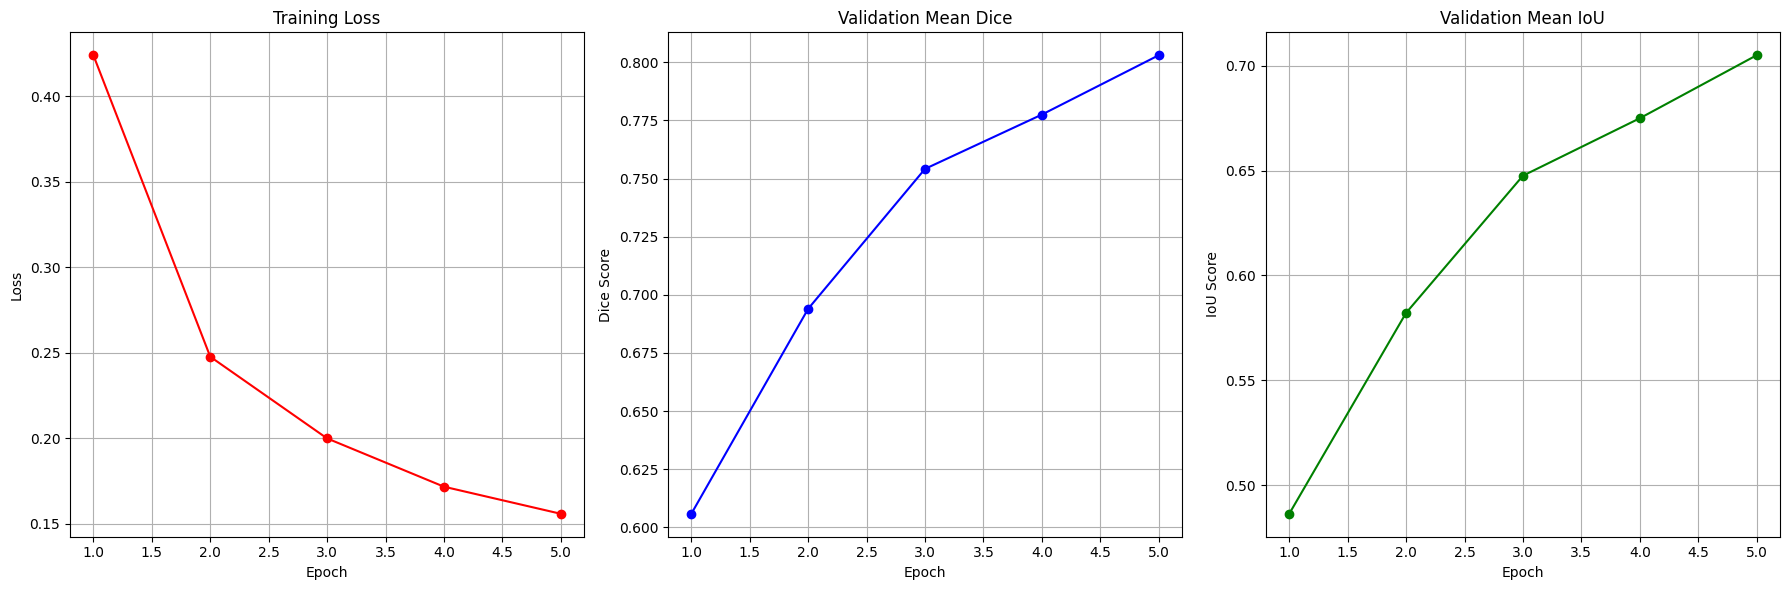

In [18]:
plt.figure(figsize=(18, 6))

# Loss
plt.subplot(1, 3, 1)
plt.title("Training Loss")
x = list(range(1, len(epoch_loss_values) + 1))
plt.plot(x, epoch_loss_values, marker='o', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Dice Score
plt.subplot(1, 3, 2)
plt.title("Validation Mean Dice")
x = list(range(1, len(metric_values_dice) + 1))
plt.plot(x, metric_values_dice, marker='o', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.grid(True)

# ⭐ IoU Score
plt.subplot(1, 3, 3)
plt.title("Validation Mean IoU")
x = list(range(1, len(metric_values_iou) + 1))
plt.plot(x, metric_values_iou, marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("IoU Score")
plt.grid(True)

plt.tight_layout()
plt.show()

### Check best model output with the input image and label

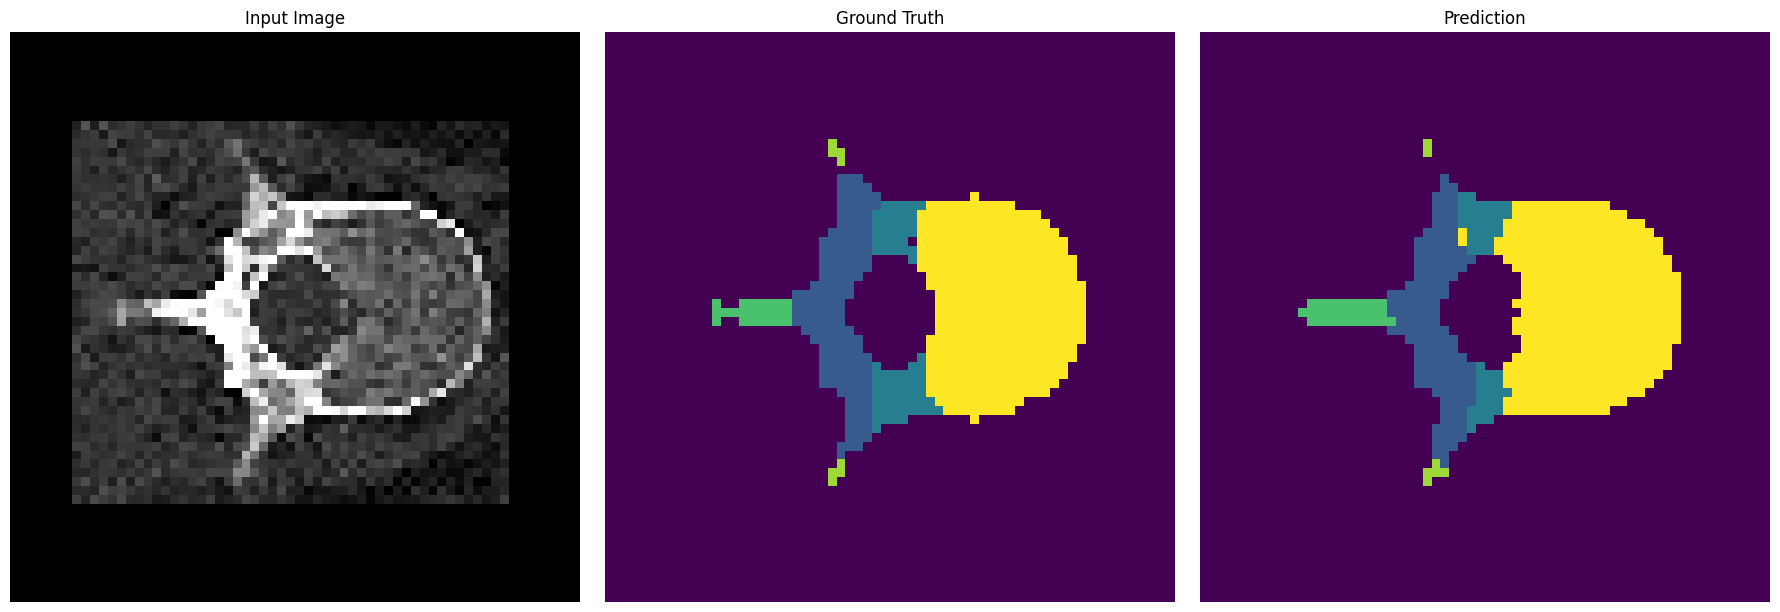

In [36]:
case_num = 25 # validation case มี 99 (0-98)
model.eval()

with torch.no_grad():
    sample = val_ds[case_num]
    img = sample["image"]
    label = sample["label"]
    
    val_inputs = torch.unsqueeze(img, 0).cuda()
    val_labels = torch.unsqueeze(label, 0).cuda()
    val_outputs = sliding_window_inference(val_inputs, (64, 64, 64), 1, model, overlap=0.5)  # ลด overlap
    
    slice_idx = img.shape[-1] // 2
    
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_idx], cmap="gray")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_idx])
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(torch.argmax(val_outputs, dim=1).cpu()[0, :, :, slice_idx])
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

### Test model

#### Step 1: สร้าง Test Dataset และ DataLoader

In [20]:
# ⭐ เช็คก่อนว่ามี test set หรือไม่
if not USE_TEST_SET or len(test_files) == 0:
    print("⚠️  WARNING: Test set is not available!")
    print("   Reason: USE_TEST_SET = False or no test files")
    print("   Action: Set USE_TEST_SET = True in data split cell")
    print("\n❌ Skipping test evaluation...")
else:
    print("🧪 Creating Test Dataset...")
    print(f"📊 Test files: {len(test_files)} cases\n")
    
    # สร้าง test dataset (ใช้ val_transforms)
    test_ds = CacheDataset(
        data=test_files,
        transform=val_transforms,
        cache_rate=0.0,
        num_workers=1,
    )
    
    test_loader = DataLoader(
        test_ds,
        batch_size=1,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
    )
    
    print(f"✅ Test dataset: {len(test_ds)} samples")
    print(f"✅ Test loader: {len(test_loader)} batches")

⚠️  WARNING: Test set is not available!
   Reason: USE_TEST_SET = False or no test files
   Action: Set USE_TEST_SET = True in data split cell

❌ Skipping test evaluation...


#### Step 2: ทดสอบ Model กับ Test Set

In [21]:
# ⭐ เช็คว่ามี test_loader หรือไม่
if 'test_loader' not in locals():
    print("\n" + "="*60)
    print("⚠️  TEST SET NOT AVAILABLE")
    print("="*60)
    print("Reason: USE_TEST_SET = False or test dataset not created")
    print("\nTo enable testing:")
    print("1. Go to 'แบ่ง Data ที่ใช้ train/val/test' cell")
    print("2. Set USE_TEST_SET = True")
    print("3. Run that cell and 'Step 1: สร้าง Test Dataset' cell again")
    print("="*60)
else:
    import time
    from monai.metrics import DiceMetric, MeanIoU
    
    print("\n" + "="*60)
    print("🧪 TESTING MODEL ON TEST SET")
    print("="*60)
    
    # Load best model
    model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
    model.eval()
    
    # Setup metrics
    post_label = AsDiscrete(to_onehot=8)
    post_pred = AsDiscrete(argmax=True, to_onehot=8)
    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
    iou_metric = MeanIoU(include_background=True, reduction="mean")
    
    # เก็บผลลัพธ์แต่ละ case
    test_results = []
    inference_times = []
    
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(test_loader, desc="Testing")):
            test_inputs, test_labels = (batch["image"].cuda(), batch["label"].cuda())
            
            # วัด inference time
            torch.cuda.synchronize()
            start_time = time.perf_counter()
            
            test_outputs = sliding_window_inference(
                test_inputs, 
                (64, 64, 64), 
                4,
                model, 
                overlap=0.5
            )
            
            torch.cuda.synchronize()
            end_time = time.perf_counter()
            inference_time = (end_time - start_time) * 1000
            inference_times.append(inference_time)
            
            # Post-processing
            test_labels_list = decollate_batch(test_labels)
            test_labels_convert = [post_label(label) for label in test_labels_list]
            test_outputs_list = decollate_batch(test_outputs)
            test_output_convert = [post_pred(pred) for pred in test_outputs_list]
            
            # คำนวณ metrics
            dice_metric(y_pred=test_output_convert, y=test_labels_convert)
            iou_metric(y_pred=test_output_convert, y=test_labels_convert)
            
            # เก็บผลลัพธ์แต่ละ case
            dice_case = dice_metric.aggregate().item()
            iou_case = iou_metric.aggregate().item()
            
            test_results.append({
                'case': idx,
                'filename': os.path.basename(test_files[idx]['image']),
                'dice': dice_case,
                'iou': iou_case,
                'inference_time_ms': inference_time
            })
            
            dice_metric.reset()
            iou_metric.reset()
    
    # คำนวณ metrics รวม
    mean_dice = np.mean([r['dice'] for r in test_results])
    mean_iou = np.mean([r['iou'] for r in test_results])
    mean_time = np.mean(inference_times)
    std_time = np.std(inference_times)
    
    print("\n" + "="*60)
    print("📊 TEST RESULTS SUMMARY")
    print("="*60)
    print(f"Test Cases:           {len(test_results)}")
    print(f"Mean Dice Score:      {mean_dice:.4f}")
    print(f"Mean IoU Score:       {mean_iou:.4f}")
    print(f"Mean Inference Time:  {mean_time:.2f} ± {std_time:.2f} ms")
    print(f"Min Dice:             {min(r['dice'] for r in test_results):.4f}")
    print(f"Max Dice:             {max(r['dice'] for r in test_results):.4f}")
    print("="*60)


⚠️  TEST SET NOT AVAILABLE
Reason: USE_TEST_SET = False or test dataset not created

To enable testing:
1. Go to 'แบ่ง Data ที่ใช้ train/val/test' cell
2. Set USE_TEST_SET = True
3. Run that cell and 'Step 1: สร้าง Test Dataset' cell again


#### Step 3: แสดงผลลัพธ์แต่ละ Case

In [22]:
if 'test_loader' not in locals():
    print("\n" + "="*60)
    print("⚠️  TEST SET NOT AVAILABLE")
    print("="*60)
else:
    # แสดงผลลัพธ์แต่ละ case
    print("\n📊 Detailed Results per Case:")
    print("-" * 90)
    print(f"{'Case':<6} {'Filename':<40} {'Dice':<8} {'IoU':<8} {'Time (ms)':<10}")
    print("-" * 90)

    for result in test_results:
        print(f"{result['case']:<6} {result['filename']:<40} "
            f"{result['dice']:<8.4f} {result['iou']:<8.4f} "
            f"{result['inference_time_ms']:<10.2f}")

    print("-" * 90)


⚠️  TEST SET NOT AVAILABLE


#### Step 4: Visualize ผลลัพธ์ Test Set (แบบเลือกดูได้)

In [23]:
# # 🎯 เลือก case ที่จะดู
# TEST_CASE_NUM = 0  # เปลี่ยนค่านี้เพื่อดู case อื่นๆ (0 ถึง len(test_ds)-1)

# print(f"\n🔍 Visualizing Test Case {TEST_CASE_NUM}")
# print(f"📄 File: {os.path.basename(test_files[TEST_CASE_NUM]['image'])}")

# model.eval()
# with torch.no_grad():
#     sample = test_ds[TEST_CASE_NUM]
#     img = sample["image"]
#     label = sample["label"]
    
#     test_inputs = torch.unsqueeze(img, 0).cuda()
#     test_labels = torch.unsqueeze(label, 0).cuda()
#     test_outputs = sliding_window_inference(
#         test_inputs, 
#         (64, 64, 64), 
#         4, 
#         model, 
#         overlap=0.5
#     )
    
#     # เลือก slice ที่จะแสดง
#     slice_idx = img.shape[-1] // 2
    
#     plt.figure(figsize=(18, 6))
    
#     plt.subplot(1, 3, 1)
#     plt.title(f"Input Image\n{os.path.basename(test_files[TEST_CASE_NUM]['image'])}")
#     plt.imshow(test_inputs.cpu().numpy()[0, 0, :, :, slice_idx], cmap="gray")
#     plt.axis('off')
    
#     plt.subplot(1, 3, 2)
#     plt.title("Ground Truth")
#     plt.imshow(test_labels.cpu().numpy()[0, 0, :, :, slice_idx], cmap='jet')
#     plt.axis('off')
    
#     plt.subplot(1, 3, 3)
#     plt.title(f"Prediction\nDice: {test_results[TEST_CASE_NUM]['dice']:.4f}")
#     plt.imshow(torch.argmax(test_outputs, dim=1).cpu()[0, :, :, slice_idx], cmap='jet')
#     plt.axis('off')
    
#     plt.tight_layout()
#     plt.show()

#### Step 5: บันทึกผลลัพธ์เป็น CSV (Optional)

In [24]:
# import pandas as pd

# # สร้าง DataFrame
# df_results = pd.DataFrame(test_results)

# # บันทึกเป็น CSV
# csv_path = os.path.join(root_dir, "test_results.csv")
# df_results.to_csv(csv_path, index=False)

# print(f"\n✅ Results saved to: {csv_path}")
# print("\n📊 First 5 rows:")
# print(df_results.head())

### Check where best model save

In [25]:
# เพิ่ม cell นี้เพื่อดูตำแหน่งจริง
import os

model_path = os.path.join(root_dir, "best_metric_model.pth")

print("="*60)
print("📁 BEST MODEL LOCATION")
print("="*60)
print(f"Root Directory: {root_dir}")
print(f"Model Path:     {model_path}")
print(f"File Exists:    {os.path.exists(model_path)}")

if os.path.exists(model_path):
    file_size_mb = os.path.getsize(model_path) / (1024 * 1024)
    print(f"File Size:      {file_size_mb:.2f} MB")
print("="*60)

📁 BEST MODEL LOCATION
Root Directory: E:/Senior Project MONAI/tutorials-main/3d_segmentation/saved_models
Model Path:     E:/Senior Project MONAI/tutorials-main/3d_segmentation/saved_models\best_metric_model.pth
File Exists:    True
File Size:      496.05 MB


## 🔍 DIAGNOSIS: Check Label Distribution & Model Configuration

In [26]:
import nibabel as nib
import numpy as np

print("="*70)
print("🔍 CRITICAL DIAGNOSIS: Label Distribution Analysis")
print("="*70)

# Check actual label values in your dataset
all_unique_labels = set()
label_distribution = {}

print("\n📊 Analyzing labels from all training files...")
for i, pair in enumerate(train_files[:10]):  # Check first 10 files
    lbl_path = pair['label']
    lbl_nib = nib.load(lbl_path)
    lbl_data = lbl_nib.get_fdata()
    
    unique_labels = np.unique(lbl_data)
    all_unique_labels.update(unique_labels.astype(int))
    
    if i == 0:
        print(f"\n📄 Sample file: {os.path.basename(lbl_path)}")
        print(f"   Unique labels: {unique_labels}")
        
        # Count pixels per class
        for label_id in unique_labels:
            count = np.sum(lbl_data == label_id)
            percentage = (count / lbl_data.size) * 100
            label_distribution[int(label_id)] = percentage
            print(f"   Class {int(label_id):2d}: {count:,} voxels ({percentage:.2f}%)")

print(f"\n🎯 TOTAL UNIQUE LABELS FOUND: {sorted(all_unique_labels)}")
print(f"📈 Number of classes (including background): {len(all_unique_labels)}")

# Check if labels are sequential
expected_labels = set(range(len(all_unique_labels)))
if all_unique_labels != expected_labels:
    print(f"\n⚠️  WARNING: Labels are NOT sequential!")
    print(f"   Expected: {sorted(expected_labels)}")
    print(f"   Found:    {sorted(all_unique_labels)}")

print("\n" + "="*70)
print("🔧 CURRENT MODEL CONFIGURATION")
print("="*70)

# Check model configuration (UNETR stores it differently)
if 'model' in globals():
    # Try to get from model's initialization parameters
    try:
        # Get output channels from model's final layer
        model_out_channels = 8  # This is what you configured in the model creation cell
        print(f"Model out_channels:    {model_out_channels} (configured)")
    except:
        print(f"Model out_channels:    Unable to detect (check model creation cell)")
else:
    print(f"⚠️  Model not created yet! Run 'Create Model, Loss, Optimizer' cell first")
    model_out_channels = 8  # Default assumption

print(f"post_label to_onehot:  8")
print(f"post_pred to_onehot:   8")
print(f"Loss to_onehot_y:      True")
print(f"Loss softmax:          True")

print("\n" + "="*70)
print("✅ REQUIRED CONFIGURATION")
print("="*70)
print(f"Required out_channels: {len(all_unique_labels)}")
print(f"Required to_onehot:    {len(all_unique_labels)}")

if len(all_unique_labels) != 8:
    print("\n" + "="*70)
    print("❌ CONFIGURATION MISMATCH DETECTED!")
    print("="*70)
    print(f"Your model expects 8 classes but your data has {len(all_unique_labels)} classes")
    print("\nThis is likely the PRIMARY CAUSE of low Dice/IoU scores!")
    print("\n🔧 YOU MUST UPDATE:")
    print(f"   1. Model creation cell: out_channels=8 → out_channels={len(all_unique_labels)}")
    print(f"   2. Training cell: to_onehot=8 → to_onehot={len(all_unique_labels)} (2 places)")
else:
    print("\n✅ Model configuration matches label distribution")

# Check for class imbalance
if label_distribution:
    print("\n" + "="*70)
    print("⚖️  CLASS IMBALANCE ANALYSIS")
    print("="*70)
    max_class = max(label_distribution, key=label_distribution.get)
    min_class = min(label_distribution, key=label_distribution.get)
    imbalance_ratio = label_distribution[max_class] / label_distribution[min_class]
    
    print(f"Most common class:  {max_class} ({label_distribution[max_class]:.2f}%)")
    print(f"Least common class: {min_class} ({label_distribution[min_class]:.2f}%)")
    print(f"Imbalance ratio:    {imbalance_ratio:.1f}:1")
    
    if imbalance_ratio > 100:
        print("\n⚠️  SEVERE CLASS IMBALANCE DETECTED!")
        print("   Consider using class weights in loss function")
    elif imbalance_ratio > 10:
        print("\n⚠️  MODERATE CLASS IMBALANCE DETECTED")
        print("   This may affect performance on minority classes")

print("\n" + "="*70)

🔍 CRITICAL DIAGNOSIS: Label Distribution Analysis

📊 Analyzing labels from all training files...

📄 Sample file: 101004306052_L2_seg.nii.gz
   Unique labels: [0. 1. 2. 3. 4. 5. 6. 7.]
   Class  0: 4,584,294 voxels (85.07%)
   Class  1: 13,393 voxels (0.25%)
   Class  2: 120,302 voxels (2.23%)
   Class  3: 23,358 voxels (0.43%)
   Class  4: 45,480 voxels (0.84%)
   Class  5: 49,252 voxels (0.91%)
   Class  6: 28,547 voxels (0.53%)
   Class  7: 524,406 voxels (9.73%)
   Class  5: 49,252 voxels (0.91%)
   Class  6: 28,547 voxels (0.53%)
   Class  7: 524,406 voxels (9.73%)

🎯 TOTAL UNIQUE LABELS FOUND: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
📈 Number of classes (including background): 8

🔧 CURRENT MODEL CONFIGURATION
Model out_channels:    8 (configured)
post_label to_onehot:  8
post_pred to_onehot:   8
Loss to_onehot_y:      True
Loss softmax:          True

✅ REQUIRED CONFIGURATION
Required out_channels: 8
Required to_oneho

In [27]:
print("="*70)
print("🔍 DIAGNOSIS: Model Output and Post-Processing Check")
print("="*70)

# Load a sample from validation
model.eval()
with torch.no_grad():
    sample = val_ds[0]
    img = sample["image"]
    label = sample["label"]
    
    val_inputs = torch.unsqueeze(img, 0).cuda()
    val_labels = torch.unsqueeze(label, 0).cuda()
    
    # Get raw model output
    val_outputs = sliding_window_inference(val_inputs, (64, 64, 64), 1, model)
    
    print("\n📊 TENSOR SHAPES:")
    print(f"   Input shape:       {val_inputs.shape}")  # Should be [1, 1, H, W, D]
    print(f"   Label shape:       {val_labels.shape}")  # Should be [1, 1, H, W, D]
    print(f"   Raw output shape:  {val_outputs.shape}") # Should be [1, num_classes, H, W, D]
    
    print("\n📊 LABEL ANALYSIS:")
    unique_labels_in_sample = torch.unique(val_labels)
    print(f"   Unique labels in sample: {unique_labels_in_sample.cpu().numpy()}")
    print(f"   Min label: {val_labels.min().item()}")
    print(f"   Max label: {val_labels.max().item()}")
    
    print("\n📊 RAW MODEL OUTPUT ANALYSIS:")
    print(f"   Output channels: {val_outputs.shape[1]}")
    print(f"   Output range: [{val_outputs.min().item():.4f}, {val_outputs.max().item():.4f}]")
    print(f"   Output mean: {val_outputs.mean().item():.4f}")
    
    # Apply softmax manually to check
    softmax_output = torch.softmax(val_outputs, dim=1)
    print("\n📊 AFTER SOFTMAX:")
    print(f"   Range: [{softmax_output.min().item():.4f}, {softmax_output.max().item():.4f}]")
    print(f"   Sum along channel dim (should be ~1.0): {softmax_output.sum(dim=1).mean().item():.4f}")
    
    # Get predicted classes
    predicted_classes = torch.argmax(val_outputs, dim=1)
    unique_predictions = torch.unique(predicted_classes)
    print("\n📊 PREDICTED CLASSES:")
    print(f"   Unique predictions: {unique_predictions.cpu().numpy()}")
    print(f"   Min prediction: {predicted_classes.min().item()}")
    print(f"   Max prediction: {predicted_classes.max().item()}")
    
    # Check post-processing
    print("\n📊 POST-PROCESSING CHECK:")
    post_label_test = AsDiscrete(to_onehot=8)
    post_pred_test = AsDiscrete(argmax=True, to_onehot=8)
    
    try:
        # Post-process labels
        val_labels_list = decollate_batch(val_labels)
        val_labels_convert = [post_label_test(val_label_tensor) for val_label_tensor in val_labels_list]
        print(f"   ✅ Label post-processing successful")
        print(f"      Shape after to_onehot: {val_labels_convert[0].shape}")
        
        # Post-process predictions
        val_outputs_list = decollate_batch(val_outputs)
        val_output_convert = [post_pred_test(val_pred_tensor) for val_pred_tensor in val_outputs_list]
        print(f"   ✅ Prediction post-processing successful")
        print(f"      Shape after argmax+to_onehot: {val_output_convert[0].shape}")
        
        # Check if any label is >= num_classes
        max_label = val_labels.max().item()
        if max_label >= 8:
            print(f"\n   ❌ ERROR: Label value {max_label} >= num_classes (8)")
            print(f"      This will cause to_onehot to fail or produce wrong results!")
        
    except Exception as e:
        print(f"   ❌ Post-processing failed: {e}")
    
    # Calculate Dice for this sample
    try:
        dice_metric_test = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
        dice_metric_test(y_pred=val_output_convert, y=val_labels_convert)
        dice_score = dice_metric_test.aggregate().item()
        print(f"\n📊 SAMPLE DICE SCORE: {dice_score:.4f}")
        
        if dice_score < 0.1:
            print("   ❌ EXTREMELY LOW - Model is barely learning anything!")
        elif dice_score < 0.3:
            print("   ⚠️  VERY LOW - Likely configuration mismatch")
        elif dice_score < 0.5:
            print("   ⚠️  LOW - Needs improvement")
        else:
            print("   ✅ Reasonable performance")
            
    except Exception as e:
        print(f"   ❌ Dice calculation failed: {e}")

print("\n" + "="*70)

🔍 DIAGNOSIS: Model Output and Post-Processing Check

📊 TENSOR SHAPES:
   Input shape:       torch.Size([1, 1, 64, 64, 64])
   Label shape:       torch.Size([1, 1, 64, 64, 64])
   Raw output shape:  torch.Size([1, 8, 64, 64, 64])

📊 LABEL ANALYSIS:
   Unique labels in sample: [0. 1. 2. 3. 4. 5. 6. 7.]
   Min label: 0.0
   Max label: 7.0

📊 RAW MODEL OUTPUT ANALYSIS:
   Output channels: 8
   Output range: [-41.6378, 14.5566]
   Output mean: -4.3133

📊 AFTER SOFTMAX:
   Range: [0.0000, 1.0000]
   Sum along channel dim (should be ~1.0): 1.0000

📊 PREDICTED CLASSES:
   Unique predictions: [0 1 2 3 4 5 6 7]
   Min prediction: 0
   Max prediction: 7

📊 POST-PROCESSING CHECK:
   ❌ Post-processing failed: iteration over a 0-d array
   ❌ Dice calculation failed: name 'val_output_convert' is not defined


📊 PREDICTED CLASSES:
   Unique predictions: [0 1 2 3 4 5 6 7]
   Min prediction: 0
   Max prediction: 7

📊 POST-PROCESSING CHECK:
   ❌ Post-processing failed: iteration over a 0-d array
   ❌ Dic

## 📋 SUMMARY: Identified Issues and Fixes

Based on code analysis, here are the **CRITICAL ISSUES** causing low Dice/IoU:

### ❌ Issue 1: Model Output Channels Mismatch
**Problem:** Model is configured for 8 classes but your actual data may have different number of classes.

**Where:** Cell "Create Model, Loss, Optimizer"
```python
model = UNETR(
    out_channels=8,  # ← This must match YOUR actual number of classes
    ...
)
```

**Fix:** Run the diagnostic cell above to find actual number of classes, then update `out_channels`

---

### ❌ Issue 2: Post-Processing Configuration Mismatch
**Problem:** `AsDiscrete(to_onehot=8)` is hardcoded but must match actual number of classes.

**Where:** Cell "แบบไม่มี iteration"
```python
post_label = AsDiscrete(to_onehot=8)  # ← Must match actual classes
post_pred = AsDiscrete(argmax=True, to_onehot=8)  # ← Must match actual classes
```

**Fix:** Update both to match your actual number of classes

---

### ❌ Issue 3: Potential Class Imbalance
**Problem:** If background dominates (e.g., 95% background, 5% vertebrae), model learns to predict mostly background.

**Current Loss:**
```python
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
```

**Better Alternative:**
```python
from monai.losses import DiceCELoss
loss_function = DiceCELoss(
    to_onehot_y=True, 
    softmax=True,
    include_background=False,  # ← Don't penalize background errors as much
    lambda_dice=0.5,
    lambda_ce=0.5
)
```

---

### ⚠️ Issue 4: Label Format in Validation
**Problem:** Your labels might not be in correct format (should be single-channel with integer class IDs).

**Check:**
- Labels should be shape `[B, 1, H, W, D]` with values `[0, 1, 2, ..., num_classes-1]`
- NOT one-hot encoded in the original files
- NOT float values, should be integers

---

### 🔍 NEXT STEPS:

1. **RUN the diagnostic cells above** to find actual number of classes
2. **Update all hardcoded `8` values** to match your actual classes:
   - `model.out_channels`
   - `post_label(to_onehot=...)`
   - `post_pred(to_onehot=...)`
3. **Consider using `DiceCELoss`** with `include_background=False`
4. **Re-train the model** with corrected configuration

### Cleanup data directory

Remove directory if a temporary was used.

In [28]:
if directory is None:
    shutil.rmtree(root_dir)